In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score

import optuna

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
data = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [4]:
data.drop('id', inplace=True, axis=1)
data = data.replace('?', np.NaN)
data.y = data.y.replace({'N': 0, 'P': 1})

In [5]:
for column in data.drop('y', axis=1).columns:
    data[column] = data[column].astype('float')

In [6]:
data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x992,x993,x994,x995,x996,x997,x998,x999,x1000,y
0,80.0,NaN,-10.0,-20.0,-10.0,150.0,NaN,-510.0,NaN,-10.0,...,20.0,60.0,-10.0,50.0,NaN,-50.0,NaN,-3860.0,-270.0,1
1,70.0,20.0,-20.0,NaN,-10.0,NaN,360.0,-440.0,-400.0,NaN,...,20.0,NaN,-90.0,50.0,NaN,-60.0,0.0,-3250.0,-750.0,1
2,80.0,NaN,20.0,-10.0,10.0,NaN,190.0,-500.0,880.0,NaN,...,10.0,NaN,NaN,60.0,-1310.0,-40.0,0.0,-3410.0,-630.0,0
3,60.0,NaN,NaN,-40.0,NaN,NaN,580.0,NaN,-200.0,-10.0,...,20.0,60.0,40.0,60.0,NaN,-50.0,NaN,-3020.0,NaN,1
4,70.0,NaN,NaN,-10.0,0.0,230.0,NaN,30.0,390.0,0.0,...,20.0,NaN,-60.0,NaN,-1410.0,-50.0,-40.0,-3500.0,-420.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,70.0,80.0,NaN,0.0,0.0,180.0,180.0,-600.0,590.0,NaN,...,20.0,60.0,NaN,40.0,-1320.0,-40.0,-20.0,-3510.0,NaN,0
19996,70.0,90.0,NaN,0.0,0.0,140.0,540.0,-380.0,NaN,-10.0,...,10.0,NaN,-40.0,50.0,NaN,NaN,-20.0,-3420.0,-510.0,0
19997,60.0,NaN,NaN,40.0,10.0,180.0,320.0,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,-1050.0,NaN,NaN,-3250.0,-520.0,0
19998,NaN,NaN,-30.0,0.0,NaN,200.0,300.0,NaN,NaN,0.0,...,10.0,70.0,NaN,40.0,NaN,-60.0,-40.0,-3500.0,-850.0,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 1001 entries, x1 to y
dtypes: float64(1000), int64(1)
memory usage: 152.7 MB


<Axes: xlabel='y', ylabel='Count'>

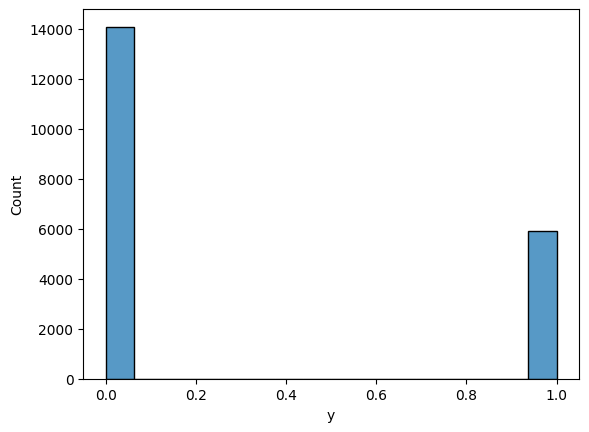

In [8]:
sns.histplot(data.y)

In [9]:
X = data.drop('y', axis=1)
y = data.y

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=52)

In [11]:
X_y_train = X_train.copy(deep=True)
X_y_train['y'] = y_train

In [12]:
# median_values = X_train.median()
# X_train = X_train.fillna(median_values)
# X_val = X_val.fillna(median_values)

In [17]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 200, 1200),
        "random_seed": trial.suggest_int("random_seed", 4, 60),
        "auto_class_weights": "Balanced",
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=0)

    preds = cat_cls.predict(X_val)
    pred_labels = np.rint(preds)
    score = f1_score(y_val, pred_labels)
    return score

In [19]:
study = optuna.create_study(study_name='CPU_stradala', direction="maximize")
study.optimize(objective, n_trials=100, timeout=800)

[I 2024-11-05 07:16:13,663] A new study created in memory with name: CPU_stradala
[I 2024-11-05 07:16:48,010] Trial 0 finished with value: 0.8681318681318682 and parameters: {'iterations': 834, 'random_seed': 19, 'colsample_bylevel': 0.03717651710123544, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.908105904698118}. Best is trial 0 with value: 0.8681318681318682.
[I 2024-11-05 07:16:54,077] Trial 1 finished with value: 0.8570258090946333 and parameters: {'iterations': 281, 'random_seed': 41, 'colsample_bylevel': 0.08899988039092147, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.31729881482156963}. Best is trial 0 with value: 0.8681318681318682.
[I 2024-11-05 07:18:51,537] Trial 2 finished with value: 0.8555696738670056 and parameters: {'iterations': 320, 'random_seed': 50, 'colsample_bylevel': 0.07953048540949166, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with va

In [35]:
study.best_trial.values, study.best_trial.params

([0.8632974316487159],
 {'iterations': 831,
  'random_seed': 47,
  'colsample_bylevel': 0.05861705348200255,
  'depth': 9,
  'boosting_type': 'Ordered',
  'bootstrap_type': 'Bernoulli',
  'subsample': 0.7070359902570923})

In [13]:
base_models = [
    ('cbs1', CatBoostClassifier(iterations=831, depth=4, boosting_type='Plain', bootstrap_type='MVS', random_seed=50, colsample_bylevel=0.0677232680438916, auto_class_weights='Balanced', silent=True)),
    ('cbs2', CatBoostClassifier(iterations=858, depth=9, boosting_type='Ordered', bootstrap_type='Bayesian', random_seed=46, colsample_bylevel=0.01588684369684712, bagging_temperature=4.466781776036623, auto_class_weights='Balanced', silent=True)),
    ('cbs3', CatBoostClassifier(iterations=500, learning_rate=0.01, random_seed=50, auto_class_weights='Balanced', silent=True))
]

# base_models = [
#     ('cbs1', CatBoostClassifier(iterations=834, depth=8, boosting_type='Plain', bootstrap_type='Bayesian', random_seed=19, colsample_bylevel=0.03717651710123544, bagging_temperature=6.908105904698118, auto_class_weights='Balanced', silent=True)),
#     ('cbs2', CatBoostClassifier(iterations=941, depth=9, boosting_type='Ordered', bootstrap_type='MVS', random_seed=44, colsample_bylevel=0.06651185634465895, bagging_temperature=4.466781776036623, auto_class_weights='Balanced', silent=True)),
#     ('cbs3', CatBoostClassifier(iterations=963, depth=9, boosting_type='Ordered', bootstrap_type='MVS', random_seed=58, colsample_bylevel=0.047491160926752415, bagging_temperature=4.466781776036623, auto_class_weights='Balanced', silent=True))
# ]

In [14]:
sc = StackingClassifier(
    estimators=base_models,
    final_estimator=RandomForestClassifier()
)

sc.fit(X_train, y_train)

StackingClassifier(estimators=[('cbs1',
                                <catboost.core.CatBoostClassifier object at 0x000001D526FAA060>),
                               ('cbs2',
                                <catboost.core.CatBoostClassifier object at 0x000001D5223A6870>),
                               ('cbs3',
                                <catboost.core.CatBoostClassifier object at 0x000001D5223A6C60>)],
                   final_estimator=RandomForestClassifier())

In [15]:
vc = VotingClassifier(
    estimators=base_models,
    voting='soft'
)

vc.fit(X_train, y_train)

VotingClassifier(estimators=[('cbs1',
                              <catboost.core.CatBoostClassifier object at 0x000001D526FAA060>),
                             ('cbs2',
                              <catboost.core.CatBoostClassifier object at 0x000001D5223A6870>),
                             ('cbs3',
                              <catboost.core.CatBoostClassifier object at 0x000001D5223A6C60>)],
                 voting='soft')

In [18]:
print(f'StackingClassifier F1 - {f1_score(sc.predict(X_val), y_val)}')
print(f'VotingClassifier F1 - {f1_score(vc.predict(X_val), y_val)}')

StackingClassifier F1 - 0.8600352112676056
VotingClassifier F1 - 0.8609053497942387


In [19]:
test

,id,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x991,x992,x993,x994,x995,x996,x997,x998,x999,x1000
0,20001,70,90,-100,?,-10,?,260,-370,-280,...,?,?,10,140,50,?,-60,?,-3200,-950
1,20002,60,40,-40,-20,-10,110,330,?,?,...,?,20,40,?,?,-1220,-50,?,-3560,-920
2,20003,80,60,?,-60,0,?,360,-540,?,...,?,20,?,100,?,-1170,-50,-10,?,?
3,20004,80,90,40,10,?,190,490,-380,?,...,?,20,20,-40,40,?,?,-40,?,?
4,20005,80,70,40,?,?,70,470,-340,630,...,50,10,30,20,40,-1700,-60,-20,?,-420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12340,32341,60,?,?,20,?,240,430,?,340,...,50,10,70,50,50,-1390,?,-10,-2890,-490
12341,32342,?,50,-30,0,20,80,360,?,-180,...,?,?,?,?,50,?,-50,?,-3010,?
12342,32343,70,?,30,?,10,170,190,-570,310,...,50,10,20,-150,?,?,-50,?,-3120,-710
12343,32344,70,20,-60,-40,-30,210,560,?,-540,...,?,?,?,-10,60,-1630,?,?,-3700,-570


In [20]:
output = test[['id']].copy(deep=True)

In [21]:
test.drop('id', inplace=True, axis=1)
test = test.replace('?', np.NaN)

In [22]:
for column in test.columns:
    test[column] = test[column].astype('float')

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12345 entries, 0 to 12344
Columns: 1000 entries, x1 to x1000
dtypes: float64(1000)
memory usage: 94.2 MB


In [37]:
#test = test.fillna(median_values)

In [27]:
prediction = cbc.predict(test)
prediction = list(map(lambda x: 'P' if x==1 else 'N', prediction))

NameError: name 'cbc' is not defined

In [25]:
output['y'] = prediction
output

,id,y
0,20001,P
1,20002,N
2,20003,N
3,20004,N
4,20005,N
...,...,...
12340,32341,P
12341,32342,N
12342,32343,N
12343,32344,N


In [26]:
output.to_csv('output.tsv', sep='\t')